__собираем статистики по объявлениям о продаже квартир__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# !pip install plotly ipywidgets plotly-geo

In [2]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import plotly
# import contextily as ctx
# from shapely.geometry import Polygon

/opt/venv/python3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()
# pd.options.plotting.backend = 'plotly'

In [4]:
# !ls -1 data

In [5]:
# import shapely
# shapely.__version__
# '1.8.4'

In [6]:
# !pip install greppo==0.0.32
# !pip install shapely==1.8.2

## считываем данные

In [7]:
data_file = 'data/data_flat.pkl'

In [8]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

30281


,title,adr,latitude,longitude,priceM,ts
30036,"1-комн. кв., 41,5 м², 3/4 этаж","Севастополь, район Ленинский, улица Пушкина, 12",44.60,33.53,6.99,2022-09-13 13:59:12.511147
1893,"3-к. квартира, 60 м², 4/5 эт.","Севастополь, проспект Победы, 22",44.59,33.56,8.00,2022-08-26 17:29:00.000000
23417,"1-комн. кв., 40,9 м², 2/10 этаж","Севастополь, район Нахимовский, улица Горпищенко, 143 к7",44.58,33.58,5.40,2022-09-13 13:59:12.511147


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30281 entries, 0 to 30280
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   title          30281 non-null  object        
 1   price          30281 non-null  int64         
 2   adr_orig       30281 non-null  object        
 3   description    30281 non-null  object        
 4   obj_name       30281 non-null  object        
 5   ts             30281 non-null  datetime64[ns]
 6   avito_page     19813 non-null  float64       
 7   place          30281 non-null  object        
 8   nrooms         30281 non-null  int64         
 9   floor          30281 non-null  int64         
 10  nfloors        30281 non-null  int64         
 11  area           30281 non-null  float64       
 12  is_studio      30281 non-null  bool          
 13  is_apartment   30281 non-null  bool          
 14  is_part        30281 non-null  bool          
 15  is_auction     3028

In [10]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

30281
30281


### ограничиваем тип объекта 

In [11]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

30281
25405


In [12]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
14485,"3-к. квартира, 76,5 м², 7/9 эт.","Севастополь, улица Токарева, 7 этап, блок-секция 2",44.584828,33.502767,10.33
1316,"3-к. квартира, 63,3 м², 5/5 эт.","Севастополь, проспект Генерала Острякова, 27",44.58,33.52,7.50
29773,"1-комн. кв., 30,7 м², 10/16 этаж","Севастополь, район Гагаринский, 5-й, улица Александра Маринеско, 1б/3",44.573592,33.465074,4.65


In [13]:
# gdf.sample(3)[['title','adr','latitude','longitude','priceM']].to_json()

In [14]:
# gdf.to_file(data_file.replace('.pkl','.shp'))

In [15]:
# gdf.to_file(data_file.replace('.pkl','.geojson'), driver='GeoJSON')

In [16]:
# gdf.to_file(data_file.replace('.pkl','.gpkg'), layer='points', driver="GPKG")

In [17]:
del df

In [18]:
gdf[['title','adr','priceM','geometry']].sample(100).explore()

## общая статистика изменение цены

In [19]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['nrooms','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)

stat

count  mean  std  min   10%   25%   50%   75%   90%    max
nrooms dt                                                                     
1      2022-08-26 1203.00  6.26 1.91 1.59  4.07  5.00  6.00  7.30  8.50  18.50
       2022-08-29 1191.00  6.25 1.90 1.75  4.11  5.00  6.00  7.21  8.50  18.50
       2022-08-31 1180.00  6.34 1.92 1.30  4.20  5.09  6.00  7.43  8.76  18.50
       2022-09-01 1159.00  6.32 1.89 1.30  4.15  5.10  6.00  7.40  8.51  18.50
       2022-09-02  365.00  6.31 2.10 3.65  4.00  4.85  5.81  7.21  9.35  14.90
       2022-09-05  372.00  6.21 2.10 3.10  3.99  4.81  5.55  7.07  9.35  14.90
       2022-09-06  372.00  6.22 2.10 3.15  3.99  4.83  5.62  7.05  9.33  14.90
       2022-09-07  320.00  6.35 2.10 3.10  4.09  4.87  5.80  7.26  9.35  14.90
       2022-09-08 1031.00  5.92 2.35 1.40  3.50  4.25  5.42  7.10  9.00  18.50
       2022-09-12  906.00  5.89 2.35 1.40  3.49  4.40  5.42  7.00  8.70  18.50
       2022-09-13  910.00  5.96 2.41 1.40  3.40  4.30  5.50  7.20  9.12  18.50
       2022-09-15  916.00  5.91 2.30 1.40  3.49  4.45  5.50  7.00  8.86  18.50
       2022-09-16  830.00  6.43 2.66 1.40  3.98  5.00  5.95  7.29  9.41  40.00
       2022-09-19  810.00  6.42 2.68 1.40  3.94  5.00  5.90  7.30  9.35  40.00
       2022-09-22  797.00  6.43 2.57 1.40  4.20  5.10  5.95  7.30  9.06  40.00
2      2022-08-26  941.00  8.82 3.30 2.80  5.80  6.60  8.15 10.21 12.67  36.00
       2022-08-29  936.00  8.87 3.30 2.80  5.88  6.70  8.19 10.42 12.64  36.00
       2022-08-31  925.00  8.83 3.20 2.60  5.80  6.69  8.10 10.35 12.85  35.00
       2022-09-01  947.00  8.91 3.32 2.65  5.80  6.70  8.18 10.50 12.90  36.00
       2022-09-02  112.00  9.66 2.65 4.91  6.36  7.55  9.43 11.53 12.97  15.70
       2022-09-05  131.00  9.76 2.70 4.92  6.40  8.00  9.28 11.37 13.65  15.70
       2022-09-06  187.00  9.71 2.69 4.91  6.32  7.83  9.28 11.45 13.65  15.70
       2022-09-07  128.00  9.75 2.85 4.91  6.20  7.49  9.14 11.77 13.93  15.70
       2022-09-08  560.00  9.44 4.16 3.20  6.00  6.74  8.39 11.13 13.65  49.12
       2022-09-12  476.00  9.25 4.34 3.00  5.70  6.60  8.22 10.88 13.63  49.12
       2022-09-13  474.00  9.16 4.38 3.00  5.65  6.54  8.18 10.61 13.60  49.12
       2022-09-15  495.00  9.10 4.16 3.00  5.90  6.60  8.18 10.60 13.58  49.12
       2022-09-16  576.00  9.45 4.12 1.70  6.07  6.98  8.32 10.80 13.63  49.12
       2022-09-19  569.00  9.30 4.11 3.20  5.90  6.90  8.25 10.79 13.50  49.12
       2022-09-22  566.00  9.32 4.13 3.20  5.90  6.80  8.25 10.80 13.50  49.12
3      2022-08-26  646.00 11.61 6.14 3.50  7.40  8.30 10.25 13.24 16.80 100.00
       2022-08-29  635.00 11.66 6.17 3.85  7.40  8.43 10.33 13.28 16.68 100.00
       2022-08-31  640.00 11.64 6.12 3.85  7.40  8.44 10.30 13.03 17.03 100.00
       2022-09-01  634.00 11.57 6.13 3.85  7.40  8.30 10.21 13.00 16.90 100.00
       2022-09-02   61.00 11.17 1.74 7.73 10.21 10.33 10.35 11.53 13.90  16.64
       2022-09-05   67.00 11.22 1.85 7.73 10.21 10.33 10.35 12.03 14.18  16.64
       2022-09-06   65.00 11.22 1.87 7.73 10.21 10.33 10.34 11.53 14.27  16.64
       2022-09-07   58.00 11.26 1.81 9.20 10.21 10.33 10.35 11.35 14.13  16.64
       2022-09-08  298.00 11.98 5.67 5.00  7.64  9.15 10.35 13.50 17.36  56.52
       2022-09-12  273.00 11.99 6.02 5.00  7.60  9.00 10.33 13.50 17.40  56.52
       2022-09-13  292.00 12.06 5.88 5.00  7.60  9.00 10.35 13.50 17.00  56.52
       2022-09-15  287.00 11.76 5.85 4.70  7.50  9.00 10.34 12.80 16.66  56.52
       2022-09-16  363.00 12.49 6.28 3.50  7.50  9.07 10.35 13.93 18.76  56.52
       2022-09-19  355.00 12.45 6.36 5.10  7.60  9.00 10.35 13.75 18.58  56.52
       2022-09-22  346.00 12.48 6.48 3.50  7.40  9.00 10.35 13.88 18.80  56.52

In [20]:
# stat_1 = stat.loc[1,['min','25%','50%']]
# [ d.strftime('%m/%d/%Y') for d in stat_1.index ]
# stat_1.values.T.tolist()

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

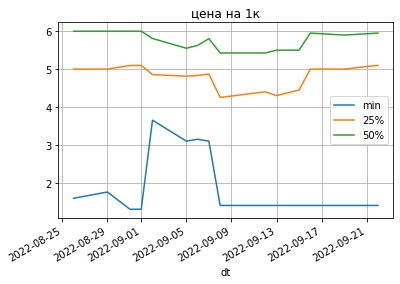

In [21]:
stat.loc[1,['min','25%','50%']].plot(title='цена на 1к', grid=True )

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

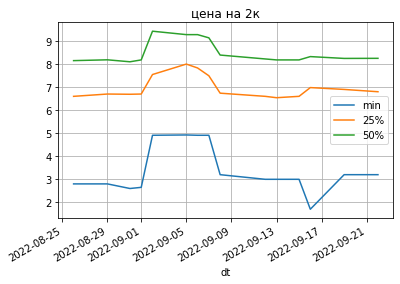

In [22]:
stat.loc[2,['min','25%','50%']].plot(title='цена на 2к',grid=True)

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

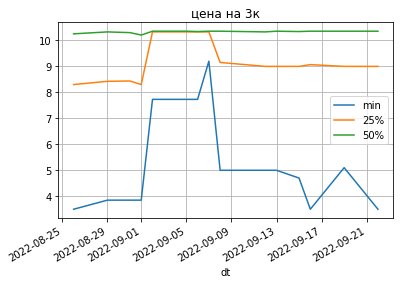

In [23]:
stat.loc[3,['min','25%','50%']].plot(title='цена на 3к',grid=True)

In [24]:
# stat.loc[2,['min']].reset_index().rename(columns={'dt':'x','min':'y'}).T.to_dict()



---

### район поиска

In [25]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [26]:
frame_all.explore()

In [27]:
frame_all.to_file('data/frame_all.geojson', driver='GeoJSON')

### гексагональная сетка

In [28]:
import h3
from shapely.geometry import Polygon

def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [29]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0],cell_size=6 )
print(len(grid))
grid.sample(2)

24


,hex_id,geometry
6,862d2d487ffffff,"POLYGON ((33.62646 44.74017, 33.60499 44.71079, 33.63190 44.68201, 33.68026 44.68260, 33.70175 44.71197, 33.67486 44.74076, 33.62646 44.74017))"
1,862d2d4b7ffffff,"POLYGON ((33.55659 44.71016, 33.53515 44.68076, 33.56208 44.65198, 33.61044 44.65261, 33.63190 44.68201, 33.60499 44.71079, 33.55659 44.71016))"


In [30]:
# grid.explore()

### медиана актуальной цены

In [31]:
ts = '2022-08-01' # ограничиваем дату

# новые предложения
gdf_ = gdf[ (gdf['dt']>ts)  ] # & (gdf['priceM']<15.)

grid_values = ( 
    grid
    .sjoin(gdf_, how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [32]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [33]:
frames.explore('area_name', legend=True)

In [34]:
frames.to_file('data/frames.geojson', driver='GeoJSON')

In [35]:
area_name=[
'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
# 'Севастополь, Малахов курган',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

25405
280


In [36]:
frames.iloc[[0]]

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"


In [37]:
# новые (актуальные) предложения
# gdf_[gdf_['ts']>ts][['title','priceM','adr','geometry']].explore( legend=False)
gdf_[['title','priceM','adr','geometry']].explore( legend=False)

### изменение цены

In [38]:
stat = gdf_.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
stat

count  mean  std  min  10%  25%  50%  75%  90%  max
nrooms dt                                                             
1      2022-08-26  11.00  5.43 0.48 4.30 4.95 5.20 5.60 5.80 5.80 5.90
       2022-08-29  14.00  5.64 0.72 4.30 4.96 5.30 5.63 5.80 6.11 7.50
       2022-08-31  14.00  5.61 0.71 4.30 4.96 5.15 5.63 5.80 6.11 7.35
       2022-09-01  14.00  5.70 0.60 4.95 5.00 5.53 5.63 5.80 6.11 7.35
       2022-09-08   6.00  5.63 0.38 4.99 5.25 5.50 5.70 5.90 5.95 6.00
       2022-09-12   6.00  5.58 0.36 4.99 5.25 5.50 5.55 5.83 5.95 6.00
       2022-09-13   5.00  5.58 0.40 4.99 5.19 5.50 5.50 5.90 5.96 6.00
       2022-09-15   5.00  5.48 0.43 4.80 5.08 5.50 5.50 5.60 5.84 6.00
       2022-09-16   5.00  5.48 0.52 4.80 5.00 5.30 5.40 5.70 6.00 6.20
       2022-09-19   5.00  5.48 0.52 4.80 5.00 5.30 5.40 5.70 6.00 6.20
       2022-09-22   8.00  5.53 0.54 4.80 4.80 5.17 5.55 6.00 6.06 6.20
2      2022-08-26  23.00  6.98 0.91 5.75 6.30 6.50 6.95 7.12 7.86 9.45
       2022-08-29  25.00  7.00 1.06 5.70 5.80 6.30 6.95 7.15 8.78 9.50
       2022-08-31  25.00  6.85 0.96 5.70 5.85 6.30 6.80 7.05 7.72 9.50
       2022-09-01  26.00  6.82 0.95 5.70 5.76 6.30 6.65 7.04 7.65 9.50
       2022-09-08   8.00  7.04 1.11 5.85 6.09 6.42 6.92 7.19 7.96 9.50
       2022-09-12   8.00  7.04 1.11 5.85 6.09 6.42 6.92 7.19 7.96 9.50
       2022-09-13   8.00  7.04 1.11 5.85 6.09 6.42 6.92 7.19 7.96 9.50
       2022-09-15   7.00  7.19 1.10 6.20 6.26 6.55 7.05 7.22 8.18 9.50
       2022-09-16  13.00  6.92 0.98 5.40 5.88 6.50 7.00 7.15 7.30 9.50
       2022-09-19  10.00  6.76 0.65 5.40 5.80 6.62 7.03 7.14 7.30 7.30
       2022-09-22  12.00  6.59 0.71 5.40 5.71 5.82 7.00 7.11 7.29 7.30
3      2022-08-26   7.00  7.53 0.50 6.90 6.90 7.20 7.70 7.70 7.94 8.30
       2022-08-29   6.00  7.50 0.54 6.90 6.90 7.05 7.60 7.70 8.00 8.30
       2022-08-31   5.00  7.46 0.59 6.90 6.90 6.90 7.50 7.70 8.06 8.30
       2022-09-01   4.00  7.60 0.58 6.90 7.08 7.35 7.60 7.85 8.12 8.30

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

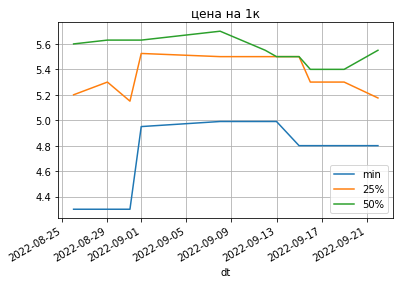

In [39]:
stat.loc[1,['min','25%','50%']].plot(title='цена на 1к',grid=True)

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

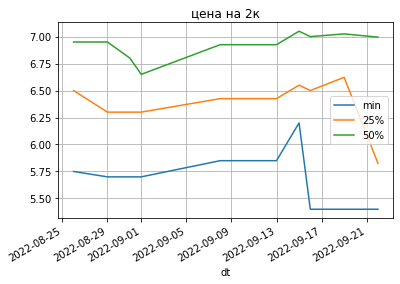

In [40]:
stat.loc[2,['min','25%','50%']].plot(title='цена на 2к',grid=True)

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

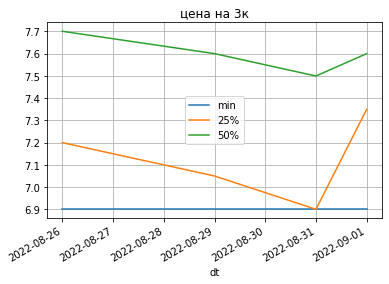

In [41]:
stat.loc[3,['min','25%','50%']].plot(title='цена на 3к',grid=True)

### гексагональная сетка

In [42]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

4


,hex_id,geometry
2,892d289405bffff,"POLYGON ((33.51520 44.58354, 33.51487 44.58175, 33.51696 44.58059, 33.51937 44.58122, 33.51969 44.58301, 33.51761 44.58417, 33.51520 44.58354))"
0,892d2894293ffff,"POLYGON ((33.51422 44.57817, 33.51390 44.57638, 33.51598 44.57522, 33.51839 44.57585, 33.51872 44.57764, 33.51663 44.57880, 33.51422 44.57817))"


### медиана актуальной цены

In [43]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)